# Pairwise differential analysis to identify cluster enriched genes

This notebook provies a guide on identifying cluster enriched genes by performing differential analysis on pairs of clusters. For each cluster, differential analysis is performed relative to all other clusters and the number of times a gene is differentially expressed is enumerated. Cluster enriched genes are differentiatlly high in the target cluster relative to all/most other clusters

The following packages need to be installed for running this notebook:
1. `scanpy`: https://scanpy.readthedocs.io/en/stable/installation.html
2. `plotly`: https://plotly.com/python/getting-started/
3. `tqdm` : https://github.com/tqdm/tqdm#installation


## Parameters

`Anndata` objects the primary input for this notebook. The data in the `anndata` object should be normalized and log-transformed. The following are the parameters that need to be specified. Defaults below are set according to our manuscript
1. `LEIDEN_NAME` represents the `anndata.obs` field the contains information about clusters for pairwise differential analysis
2. `ARG_PAIRWISE_LOG_FC_MIN`: Is the minimum log FC for a gene to be differentially high in a cluster
3. `ARG_PAIRWISE_PVAL_CUTOFF`: Is the p-value cutoff for a gene to be differentially high in a cluster

In [1]:
LEIDEN_NAME = 'leiden_postBC'
ARG_PAIRWISE_LOG_FC_MIN = 1.5
ARG_PAIRWISE_PVAL_CUTOFF = 1e-25

Now, import the necessary packages along with plotting presets

## Imports

In [2]:
# data related
import anndata as AnnData
import numpy as np
import pandas as pd
import scanpy as sc

# plotly plots -- heatmaps
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

# other data vis packages
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style

# utils -- for loading bar
import tqdm
import os

import warnings
from numba.core.errors import NumbaDeprecationWarning

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)



In [3]:
# Plotting presets
%matplotlib inline
style.use('ggplot')

# config for matplotlib
matplotlib.rcParams['figure.figsize'] = [5,5]
matplotlib.rcParams['figure.dpi'] = 2000
matplotlib.rcParams['image.cmap'] = 'Spectral_r'

# config for scanpy
sc.settings.verbosity = 0
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')


/home/msetty/micromamba/envs/glia/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.24.4 scipy==1.11.1 pandas==2.0.3 scikit-learn==1.3.0 statsmodels==0.14.0 pynndescent==0.5.10


In [4]:
# for deterministic behaviour/reproducibility
seed = 1
np.random.seed(seed)

In [5]:
PLOTLY_COLOR_TEMPLATE = 'plotly_white'
HEATMAP_COLOR = [[0,'rgb(250,250,250)'], [1,'rgb(102,0,204)']]
HEATMAP_MIN_COLOR = 0
HEATMAP_MAX_COLOR = 4

A set of utility functions for performing and plotting pairwise differential analysis


## Utility functions

In [6]:
def pairwise_differential_analysis(adata, target_cluster, leiden_name, min_logfc, pval_cutoff):
    """
    [Summary]
        Performs a pairwise comparison for a single target cluster. If there are N clusters this 
        function will perform a pairwise comparison N-1 times iteratively. 
    [Parameters]
            target_cluster  --   A target cluster/group of interest within the columns containing
                                 clusters/groups within the AnnData.obs metadata of an anndata object
            leiden_name     --   The column name or key containing cluster/groups
            min_logfc       --   Minimum fold change for differential expression
            pval_cutoff     --   P-value cutoff for differential expression 
    [Returns]
        Returns a list of dataframes of every comparison made during pairwise 
        for the target cluster
    """
    reference_clusters = adata.obs.loc[adata.obs[LEIDEN_NAME] != target_cluster][LEIDEN_NAME].unique()
    target_cluster_results = []
    for cluster_reference in reference_clusters:
        sc.tl.rank_genes_groups(
            adata,
            use_raw=False,
            key_added=f'target_cluster_{target_cluster}vs{cluster_reference}',
            groupby=LEIDEN_NAME,
            groups=[target_cluster], 
            reference=cluster_reference,
        )
        
        de_results = sc.get.rank_genes_groups_df(
            adata, 
            key=f'target_cluster_{target_cluster}vs{cluster_reference}', 
            group=[target_cluster], 
            log2fc_min=min_logfc,
            pval_cutoff=pval_cutoff, #if we dont set a cut off -- differentially expressed genes will basically appear, 1e-200 is too low...
        )
        
        # add a versus columns to the dataframe
        de_results['group'] = de_results.shape[0] * [target_cluster]
        de_results['compared_against'] = de_results.shape[0] * [cluster_reference]
        
        target_cluster_results.append(de_results)
    return target_cluster_results

In [7]:
def add_pairwise_results_to_adnndata(adata, pairwise_results, leiden_name):

    # ##########
    # Pairwise results 
    
    # create a pandas dataframe to store pairwise counts -- gene by cluster
    pairwise_counts_matrix = pd.DataFrame(0, index=adata.var_names, columns=adata.obs[leiden_name].values.categories)
    cluster_list = adata.obs[leiden_name].values.categories.tolist()
    df_mp_GroupCounts = df_mp.loc[:,['names','group']].groupby(['group','names']).agg({'names':'count'}).rename(columns={'names':'gene_counts'})
    
    for cluster in tqdm.tqdm(cluster_list, total=len(cluster_list), desc='Adding count values'):
        clust_specific_genes = df_mp_GroupCounts.loc[cluster,:].index.tolist()
        clust_specific_genes_count = df_mp_GroupCounts.loc[cluster].values.ravel()
        pairwise_counts_matrix.loc[clust_specific_genes,cluster] = clust_specific_genes_count

    # add the pairwise counts matrix to adata varm
    adata.varm['pairwise_cluster_count'] = pairwise_counts_matrix.copy()


    # ##########
    # Mean expression per cluster
    
    # create mean expression matrix
    expression_matrix = pd.DataFrame(adata.X.toarray().copy(), index=adata.obs_names, columns=adata.var_names)
    
    # add a cluster column to groupby and compute the means matrix with
    expression_matrix.loc[:,'leiden_cluster'] = adata.obs.loc[:,leiden_name].copy()

    # compute th mean matrix -- mean expression of genes per cluster
    mean_expression_matrix = expression_matrix.groupby('leiden_cluster').mean()

    # gene by clusters with entries being mean expression 
    adata.varm['cluster_means'] = mean_expression_matrix.T.copy()


In [8]:
def plot_pairwise_results(adata, target_cluster, save=None):
    """
    [Summary]
        Plots pairwise results for the target cluster
    [Parameters]
            adata           --   Anndata object with the pairwise results 
            target_cluster  --   A target cluster/group of interest within the columns containing
                                 clusters/groups within the AnnData.obs metadata of an anndata object
    """
    
    # Pairwise results for the target cluster 
    cluster_res = adata.varm['pairwise_cluster_count'].loc[:,target_cluster].sort_values(ascending=False).to_frame().copy().rename(columns={target_cluster:'counts'})
    cluster_res = cluster_res.loc[cluster_res['counts'] > 0]
    exp_mat = adata.varm['cluster_means'].loc[cluster_res.index]

    # Histogram Plots
    Hist_Counts = go.Bar(
        x=cluster_res.index,
        y=cluster_res['counts'],
        marker=dict(
            color='slateblue'
        ),
        opacity=0.6
    )

    # Heatmap Plot
    Matrix_Heatmap = go.Heatmap(
        z=exp_mat.T,
        x=exp_mat.index,
        y=exp_mat.columns,
        colorscale=HEATMAP_COLOR,
        zmin=HEATMAP_MIN_COLOR,
        zmax=HEATMAP_MAX_COLOR,
        colorbar={
            'len': 0.68,
            'y': 0.40
        }
    )

    # Put the plot together
    subplot = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.02, row_heights=[0.3,0.9])
    plots = [Hist_Counts, Matrix_Heatmap]
    
    # add plotly graph objects onto the subplots
    for row in range(len(plots)):
        subplot.add_trace(
            plots[row],
            row=row + 1,
            col=1
        )
        
    # customize/update layouts
    subplot.update_layout(
        template=PLOTLY_COLOR_TEMPLATE,
        height=600,
        width=1000,
        title=dict(
            text=f'Cluster {target_cluster} | Pairwise Analysis Results -- Cluster Specific Genes'
        ),
        xaxis=dict(
            showgrid=False
        ),
        yaxis=dict(
            showgrid=False,
            title='Pairwise Comparison<br>Gene Counts'
        ),
        xaxis2=dict(
            showgrid=False,
        ),
        yaxis2=dict(
            showgrid=False,
            title='Mean Gene Expression<br>Across Leiden Clusters'
        ),
        xaxis3=dict(
            showgrid=False,
            title='Cluster Specific Genes'
        ),
        yaxis3=dict(
            visible=False,
            showgrid=False
        ),
    )

    # Save and show 
    if save is not None:
        subplot.write_image(save)

    return subplot

## Example data

We use glial cells described in our manuscript as the example for demonstrating pairwise differential results. 

The anndata can be downloaded from the URL below. Replace the path in `line 2` with your anndata object 

In [9]:
ad_url = "https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/worm-glia-atlas/GliaOnly.h5ad"
adata = sc.read("data/GliaOnly.h5ad", backup_url=ad_url)
adata

AnnData object with n_obs × n_vars = 20810 × 12376
    obs: 'Celltype', 'sex_specificity', 'leiden_postBC', 'sex', 'SheathSocket_label', 'Compartments', 'leiden_preBC', 'cluster_sex_label', 'Cluster_Celltype'
    var: 'highly_variable', 'previous_highly_variable', 'transcription_factors', 'transporters'
    uns: 'BatchCorrected_LeidenClusters_colors', 'Compartments_colors', 'Identified_SheathSocket_Markers', 'SheathSocket_label_colors', 'Validations_colors', 'cluster_sex_label_colors', 'dendrogram_Cluster_Celltype', 'gene_validations', 'leiden_noBC_colors', 'leiden_postBC_colors', 'sex_colors', 'sex_frac_Glia_postBC', 'sex_specificity_colors'
    obsm: 'DM_EigenVectors_postBC', 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_noBC'
    varm: 'cluster_means', 'pairwise_cluster_count'
    layers: 'magic_imputed_postBC'

This anndata object contains several metadata information which we visualize below. `LEIDEN_NAME` is used for pairwise differential analysis

/home/msetty/micromamba/envs/glia/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/msetty/micromamba/envs/glia/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/msetty/micromamba/envs/glia/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/msetty/micromamba/envs/glia/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


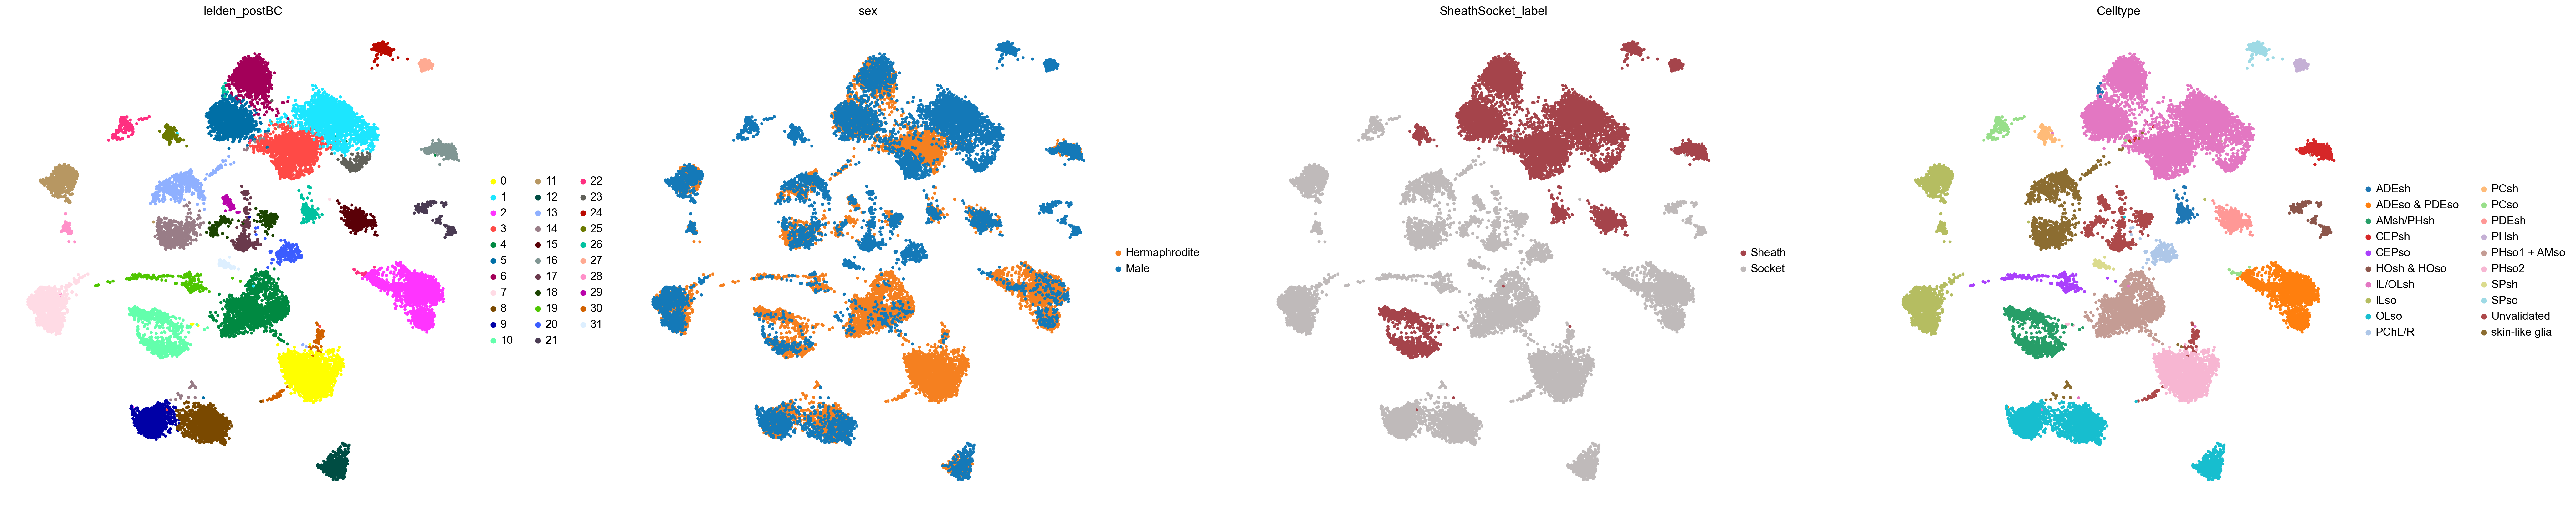

In [10]:
with matplotlib.pyplot.rc_context({'figure.figsize':(10,10)}):
    sc.pl.embedding(
        adata,
        color=[LEIDEN_NAME, 'sex', 'SheathSocket_label', 'Celltype'],
        frameon=False,
        size=50,
        basis='umap',
        wspace=0.2
    )

## Pairwise Differential Expression Analysis 

Pairwise differential expression analysis for each pair of clusters can be performed using the code snippet below. The results are computed in a dataframe and then added to the anndata object. 

<b>NOTE: </b> The anndata object is modified with the following information
1. `adata.varm['pairwise_cluster_count']`: Gene X Cluster matrix indicating how many comparisons the gene is differential.
2. `adata.varm['cluster_means']`: Gene X Cluster matrix of mean expression of gene per cluster.

In [11]:
# package the arguments
clusters = adata.obs[LEIDEN_NAME].unique()

# Pairwise analysis per cluster
# N x (N-1) computation will be done
target_cluster_results = []
for cluster in tqdm.tqdm(clusters):
    result = pairwise_differential_analysis(adata, cluster, 
                                LEIDEN_NAME, ARG_PAIRWISE_LOG_FC_MIN, ARG_PAIRWISE_PVAL_CUTOFF)
    target_cluster_results += result
    
# Consolidate pairwise results via concatenation each pairwise results should be accessible by 'group'
df_mp = pd.concat(target_cluster_results, axis=0)

100%|██████████| 32/32 [01:42<00:00,  3.22s/it]


In [12]:
# Add to anndata
add_pairwise_results_to_adnndata(adata, df_mp, LEIDEN_NAME)

Adding count values: 100%|██████████| 32/32 [00:00<00:00, 1317.54it/s]


Results can be visualized with the `plot_pairwise_results` function

## Plot

In [13]:
plot_pairwise_results(adata, '24', save=None)

Specify the `save` parameter with a png filename to save the image

Save the anndata object with the pairwise differential analysis results 
`adata.write(<Path>)`